# Hallucination Detection with RAG
This notebook implements hallucination detection using the FEVER dataset, including RAG and LLM-based verification.

In [1]:
# Improved Hallucination Detection System with RAG
# This code implements a complete pipeline for hallucination detection using the FEVER dataset
# with class balancing and Retrieval-Augmented Generation (RAG)


import pandas as pd
import numpy as np
import json
import re
import string
import random
import time
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

# For ML and NLP processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sentence_transformers import SentenceTransformer
import torch
import spacy

# For RAG components
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
import openai

# Create a global cache dictionary and path
CACHE_FILE = "/Users/shubhamgaur/Desktop/NU/Sem4/IR/Project/Milestone2/llm_response_cache.json"

# Load existing cache (if available)
if os.path.exists(CACHE_FILE):
    with open(CACHE_FILE, "r") as f:
        llm_cache = json.load(f)
else:
    llm_cache = {}

# Load spaCy model for entity extraction
try:
    nlp = spacy.load("en_core_web_sm")
except:
    print("Installing spaCy model...")
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")

# Enable tqdm for Pandas
tqdm.pandas()

## # Part 1: Data Loading and Preprocessing

In [2]:
# Path to the local FEVER dataset file
FILE_PATH = "/Users/shubhamgaur/Desktop/NU/Sem4/IR/Project/Milestone2/train.jsonl"

def load_fever_dataset(file_path):
    """Load FEVER dataset from JSONL file."""
    data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            data.append(json.loads(line))
    
    df = pd.DataFrame(data)
    return df

def clean_text(text):
    """Clean text but preserve important information."""
    if not isinstance(text, str):
        return ""
    
    # Less aggressive cleaning to preserve semantic meaning
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)  # Remove text inside brackets
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    # Don't remove digits as they can be important
    # Don't remove all punctuation as it can change meaning
    text = re.sub(r'[^\w\s.,;?!-]', '', text)  # Keep some punctuation
    text = text.strip()
    return text

def format_evidence(evidence):
    """Format evidence for better processing."""
    if not evidence:
        return "No evidence provided."
    
    # Handle nested list structure
    if isinstance(evidence, list):
        # Flatten list and convert all items to strings
        flattened = []
        for item in evidence:
            if isinstance(item, list):
                for subitem in item:
                    if isinstance(subitem, list) and len(subitem) >= 3:
                        # FEVER evidence is often [doc_id, sent_id, text]
                        if subitem[2] is not None:
                            flattened.append(str(subitem[2]))
                    else:
                        if subitem is not None:
                            flattened.append(str(subitem))
            elif item is not None:
                flattened.append(str(item))
        
        return " ".join(flattened) if flattened else "No relevant evidence found."
    
    return str(evidence)

def extract_entities(text):
    """Extract named entities from text."""
    doc = nlp(text)
    return set([ent.text.lower() for ent in doc.ents])

def entity_overlap(claim, evidence):
    """Calculate entity overlap between claim and evidence."""
    claim_entities = extract_entities(claim)
    evidence_entities = extract_entities(evidence)
    
    if not claim_entities:
        return 0.0
    
    overlap = claim_entities.intersection(evidence_entities)
    return len(overlap) / len(claim_entities)

def semantic_similarity(claim, evidence, model):
    """Calculate semantic similarity between claim and evidence."""
    claim_emb = model.encode([claim])[0]
    evidence_emb = model.encode([evidence])[0]
    return torch.nn.functional.cosine_similarity(
        torch.tensor(claim_emb).unsqueeze(0),
        torch.tensor(evidence_emb).unsqueeze(0)
    ).item()

## # Part 2: Main Data Processing Pipeline

In [ ]:
def process_fever_data(file_path, balanced_sampling=True):
    """Process FEVER dataset with option for balanced sampling."""
    print("Loading FEVER dataset...")
    df_fever = load_fever_dataset(file_path)
    print(f"Dataset loaded with {len(df_fever)} entries.")
    
    # Select necessary columns
    columns_to_keep = ['id', 'claim', 'evidence', 'label']
    df_fever = df_fever[columns_to_keep]
    
    # Handle missing values
    df_fever.dropna(inplace=True)
    
    # Convert labels to numeric encoding
    label_mapping = {"SUPPORTS": 2, "REFUTES": 1, "NOT ENOUGH INFO": 0}
    df_fever['label'] = df_fever['label'].map(label_mapping)
    
    # Clean text
    print("Cleaning text data...")
    df_fever['claim_cleaned'] = df_fever['claim'].apply(clean_text)
    
    # Format evidence properly
    print("Formatting evidence...")
    df_fever['evidence_cleaned'] = df_fever['evidence'].apply(format_evidence)
    
    # Remove Duplicate Claims
    df_fever.drop_duplicates(subset=['claim'], inplace=True)
    
    # Print dataset statistics
    print("\nDataset Statistics:")
    print(f"Total Claims: {len(df_fever)}")
    print(df_fever['label'].value_counts())
    
    # Balanced sampling if requested
    if balanced_sampling:
        print("\nPerforming balanced sampling...")
        # Find the class with minimum samples
        min_class_count = df_fever['label'].value_counts().min()
        
        # Sample equal number from each class
        df_supports = df_fever[df_fever['label'] == 2].sample(min_class_count, random_state=42)
        df_refutes = df_fever[df_fever['label'] == 1].sample(min_class_count, random_state=42)
        df_nei = df_fever[df_fever['label'] == 0].sample(min_class_count, random_state=42)
        
        # Combine balanced dataset
        df_balanced = pd.concat([df_supports, df_refutes, df_nei])
        df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
        
        print("\nBalanced Dataset Statistics:")
        print(f"Total Claims: {len(df_balanced)}")
        print(df_balanced['label'].value_counts())
        
        return df_balanced
    
    return df_fever

def create_train_val_test_split(df):
    """Split dataset into train, validation, and test sets."""
    print("Splitting data into train, validation, and test sets...")
    
    # Splitting with stratification to maintain class distribution
    train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
    val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['label'])
    
    print(f"Training set size: {len(train_data)}")
    print(f"Validation set size: {len(val_data)}")
    print(f"Test set size: {len(test_data)}")
    
    return train_data, val_data, test_data

def add_nlp_features(train_data, val_data, test_data):
    """Add NLP features for improved classification."""
    print("Adding NLP features...")
    
    # Load the sentence transformer model
    sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Add similarity feature
    print("Calculating semantic similarities...")
    train_data['similarity_score'] = train_data.progress_apply(
        lambda x: semantic_similarity(x['claim_cleaned'], x['evidence_cleaned'], sentence_model), 
        axis=1
    )
    val_data['similarity_score'] = val_data.progress_apply(
        lambda x: semantic_similarity(x['claim_cleaned'], x['evidence_cleaned'], sentence_model), 
        axis=1
    )
    test_data['similarity_score'] = test_data.progress_apply(
        lambda x: semantic_similarity(x['claim_cleaned'], x['evidence_cleaned'], sentence_model), 
        axis=1
    )
    
    # Add entity overlap feature
    print("Calculating entity overlaps...")
    train_data['entity_overlap'] = train_data.progress_apply(
        lambda x: entity_overlap(x['claim_cleaned'], x['evidence_cleaned']), 
        axis=1
    )
    val_data['entity_overlap'] = val_data.progress_apply(
        lambda x: entity_overlap(x['claim_cleaned'], x['evidence_cleaned']), 
        axis=1
    )
    test_data['entity_overlap'] = test_data.progress_apply(
        lambda x: entity_overlap(x['claim_cleaned'], x['evidence_cleaned']), 
        axis=1
    )
    
    # Add claim length feature
    train_data['claim_length'] = train_data['claim_cleaned'].apply(lambda x: len(x.split()))
    val_data['claim_length'] = val_data['claim_cleaned'].apply(lambda x: len(x.split()))
    test_data['claim_length'] = test_data['claim_cleaned'].apply(lambda x: len(x.split()))
    
    # Add evidence length feature
    train_data['evidence_length'] = train_data['evidence_cleaned'].apply(lambda x: len(x.split()))
    val_data['evidence_length'] = val_data['evidence_cleaned'].apply(lambda x: len(x.split()))
    test_data['evidence_length'] = test_data['evidence_cleaned'].apply(lambda x: len(x.split()))
    
    return train_data, val_data, test_data

## # Part 3: RAG Implementation

In [4]:
def setup_rag_system(train_data):
    """Set up a Retrieval-Augmented Generation system using evidence in the training data."""
    print("Setting up RAG system...")
    
    # Create a corpus of evidence documents
    documents = []
    
    for idx, row in tqdm(train_data.iterrows(), total=len(train_data)):
        # Use each evidence as a document with metadata about the claim and label
        documents.append(
            Document(
                page_content=row['evidence_cleaned'],
                metadata={
                    'claim_id': row['id'] if 'id' in row else idx,
                    'claim': row['claim_cleaned'],
                    'label': row['label']
                }
            )
        )
    
    # Split documents for better retrieval
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=50
    )
    split_documents = text_splitter.split_documents(documents)
    
    print(f"Created {len(split_documents)} document chunks for RAG")
    
    # Create vector embeddings
    embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
    
    # Create vector store
    vector_store = FAISS.from_documents(split_documents, embeddings)
    
    print("RAG system setup complete")
    return vector_store

def retrieve_relevant_evidence(vector_store, claim, k=3):
    """Retrieve relevant evidence for a claim using RAG."""
    # Search for similar evidence
    relevant_docs = vector_store.similarity_search(claim, k=k)
    
    # Extract evidence and metadata
    results = []
    for doc in relevant_docs:
        results.append({
            'evidence': doc.page_content,
            'claim': doc.metadata.get('claim', ''),
            'label': doc.metadata.get('label', '')
        })
    
    return results

def augment_evidence_with_rag(test_data, vector_store):
    """Augment test data with additional evidence from RAG."""
    print("Augmenting test data with RAG-retrieved evidence...")
    
    enhanced_evidence = []
    enhanced_labels = []
    
    for idx, row in tqdm(test_data.iterrows(), total=len(test_data)):
        # Get original evidence and claim
        original_evidence = row['evidence_cleaned']
        claim = row['claim_cleaned']
        
        # Retrieve relevant evidence
        retrieved_docs = retrieve_relevant_evidence(vector_store, claim, k=3)
        
        # Combine original and retrieved evidence
        additional_evidence = [doc['evidence'] for doc in retrieved_docs]
        combined_evidence = original_evidence + " " + " ".join(additional_evidence)
        
        # Also collect the labels from the retrieved evidence for potential use
        retrieved_labels = [doc['label'] for doc in retrieved_docs]
        
        enhanced_evidence.append(combined_evidence)
        enhanced_labels.append(retrieved_labels)
    
    test_data['rag_evidence'] = enhanced_evidence
    test_data['retrieved_labels'] = enhanced_labels
    
    # Update similarity and entity overlap using augmented evidence
    sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
    
    test_data['rag_similarity'] = test_data.progress_apply(
        lambda x: semantic_similarity(x['claim_cleaned'], x['rag_evidence'], sentence_model), 
        axis=1
    )
    
    test_data['rag_entity_overlap'] = test_data.progress_apply(
        lambda x: entity_overlap(x['claim_cleaned'], x['rag_evidence']), 
        axis=1
    )
    
    return test_data

## # Part 4: LLM Integration and Evaluation

In [53]:
def create_enhanced_prompt(claim, evidence):
    """Create an enhanced prompt for LLM verification."""
    return f"""
Task: Fact verification - determine if the claim is supported by, refuted by, or lacks sufficient evidence.

Claim: {claim}

Evidence: {evidence}

Steps to follow:
1. Analyze the key entities and relationships in the claim
2. Check if these entities and relationships are present in the evidence
3. Determine if the evidence directly supports or contradicts the claim
4. If evidence is insufficient to make a determination, indicate so

Based on your analysis, classify as one of:
- "Supported" (evidence confirms the claim)
- "Refuted" (evidence contradicts the claim) 
- "Not Enough Information" (evidence is insufficient)

Classification: 
"""

def create_rag_prompt(claim, evidence, retrieved_evidence):
    """Create a prompt that incorporates RAG-retrieved evidence."""
    return f"""
Task: Fact verification - determine if the claim is supported by, refuted by, or lacks sufficient evidence.

Claim: {claim}

Primary Evidence: {evidence}

Additional Related Evidence:
{retrieved_evidence}

Based on ALL the evidence provided (both primary and additional), classify the claim as one of:
- "Supported" (evidence confirms the claim)
- "Refuted" (evidence contradicts the claim) 
- "Not Enough Information" (evidence is insufficient)

Classification: 
"""

# from openai import OpenAI
# client = OpenAI()

import openai

def query_llm_with_retry(prompt, model="gpt-4", max_retries=3, delay=5):
    if prompt in llm_cache:
        return llm_cache[prompt]  # Use cached result

    for attempt in range(max_retries):
        try:
            response = openai.ChatCompletion.create(
                model=model,
                messages=[{"role": "user", "content": prompt}]
            )
            content = response['choices'][0]['message']['content'].strip()
            llm_cache[prompt] = content
            return content
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt < max_retries - 1:
                time.sleep(delay)
    return "API Error"


def parse_llm_response(response):
    """Convert LLM text response to label."""
    response = response.lower()
    if 'supported' in response or 'support' in response:
        return 2
    elif 'refuted' in response or 'refute' in response or 'contradict' in response:
        return 1
    else:
        return 0  # Not Enough Information

def evaluate_standard_approach_batched(test_data, sample_size=500, batch_size=20):
    print(f"Evaluating standard LLM approach with sample size {sample_size} using batch size {batch_size}...")

    # Sample from test data
    sample_data = test_data.sample(sample_size, random_state=42).reset_index(drop=True)

    # Generate prompts
    sample_data['standard_prompt'] = sample_data.apply(
        lambda x: create_enhanced_prompt(x['claim_cleaned'], x['evidence_cleaned']), axis=1
    )

    # Store predictions
    llm_responses = []

    for i in tqdm(range(0, sample_size, batch_size)):
        batch = sample_data.iloc[i:i+batch_size]
        for prompt in batch['standard_prompt']:
            response = query_llm_with_retry(prompt)
            llm_responses.append(response)

    sample_data['llm_response'] = llm_responses
    sample_data['llm_pred'] = sample_data['llm_response'].apply(parse_llm_response)

    accuracy = accuracy_score(sample_data['label'], sample_data['llm_pred'])
    report = classification_report(sample_data['label'], sample_data['llm_pred'])

    print(f"\nStandard approach accuracy (sample size {sample_size}): {accuracy:.4f}")
    print(report)

    return sample_data, accuracy

def evaluate_rag_approach_batched(test_data, sample_size=500, batch_size=20):
    print(f"Evaluating RAG-enhanced LLM approach with sample size {sample_size} using batch size {batch_size}...")

    sample_data = test_data.sample(sample_size, random_state=42).reset_index(drop=True)

    # Generate prompts
    sample_data['rag_prompt'] = sample_data.apply(
        lambda x: create_rag_prompt(
            x['claim_cleaned'],
            x['evidence_cleaned'],
            x['rag_evidence'] if 'rag_evidence' in x else ''
        ),
        axis=1
    )

    # Store responses
    rag_llm_responses = []

    for i in tqdm(range(0, sample_size, batch_size)):
        batch = sample_data.iloc[i:i+batch_size]
        for prompt in batch['rag_prompt']:
            response = query_llm_with_retry(prompt)
            rag_llm_responses.append(response)

    sample_data['rag_llm_response'] = rag_llm_responses
    sample_data['rag_llm_pred'] = sample_data['rag_llm_response'].apply(parse_llm_response)

    accuracy = accuracy_score(sample_data['label'], sample_data['rag_llm_pred'])
    report = classification_report(sample_data['label'], sample_data['rag_llm_pred'])

    print(f"\nRAG-enhanced approach accuracy (sample size {sample_size}): {accuracy:.4f}")
    print(report)

    return sample_data, accuracy

def train_ml_model(train_data, val_data):
    """Train a machine learning model for hallucination detection."""
    print("Training ML model...")

    # Prepare features
    X_train = train_data[['claim_cleaned', 'evidence_cleaned', 'similarity_score', 'entity_overlap', 'claim_length', 'evidence_length']]
    y_train = train_data['label']
    X_val = val_data[['claim_cleaned', 'evidence_cleaned', 'similarity_score', 'entity_overlap', 'claim_length', 'evidence_length']]
    y_val = val_data['label']

    # Custom transformers
    class ColumnSelector(BaseEstimator, TransformerMixin):
        def __init__(self, column_name):
            self.column_name = column_name

        def fit(self, X, y=None):
            return self

        def transform(self, X):
            return X[self.column_name]

    class NumericFeatureExtractor(BaseEstimator, TransformerMixin):
        def __init__(self, columns):
            self.columns = columns

        def fit(self, X, y=None):
            return self

        def transform(self, X):
            return X[self.columns].values

    # Create feature pipeline
    features = FeatureUnion([
        ('claim_tfidf', Pipeline([
            ('selector', ColumnSelector('claim_cleaned')),
            ('tfidf', TfidfVectorizer(max_features=1000))
        ])),
        ('evidence_tfidf', Pipeline([
            ('selector', ColumnSelector('evidence_cleaned')),
            ('tfidf', TfidfVectorizer(max_features=1000))
        ])),
        ('numeric_features', NumericFeatureExtractor(['similarity_score', 'entity_overlap', 'claim_length', 'evidence_length']))
    ])

    # Create and train random forest model
    rf_model = Pipeline([
        ('features', features),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])

    print("Fitting model...")
    rf_model.fit(X_train, y_train)

    # Validate
    val_pred = rf_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_pred)

    print(f"Validation accuracy: {val_accuracy:.4f}")

    return rf_model

def ensemble_prediction(ml_pred, llm_pred, confidence=0.7):
    """Create ensemble prediction combining ML and LLM approaches."""
    # If LLM and ML agree, return their prediction
    if ml_pred == llm_pred:
        return ml_pred
    
    # If they disagree, trust LLM more (can be adjusted)
    if confidence > 0.5:
        return llm_pred
    else:
        return ml_pred

def evaluate_ensemble_approach_batched(test_data, ml_model, rag_results, sample_size=500):
    """Evaluate ensemble approach combining ML model and RAG-enhanced LLM."""
    print(f"Evaluating Ensemble approach with sample size {sample_size}...")

    # Ensure same sample as used in rag_results
    sample_data = rag_results.copy().reset_index(drop=True)

    # Get ML model predictions
    X_test_sample = sample_data[['claim_cleaned', 'evidence_cleaned', 'similarity_score',
                                 'entity_overlap', 'claim_length', 'evidence_length']]
    ml_preds = ml_model.predict(X_test_sample)

    sample_data['ml_pred'] = ml_preds

    # Combine predictions using confidence logic (LLM favored)
    sample_data['ensemble_pred'] = sample_data.apply(
        lambda x: ensemble_prediction(x['ml_pred'], x['rag_llm_pred']), axis=1
    )

    accuracy = accuracy_score(sample_data['label'], sample_data['ensemble_pred'])
    report = classification_report(sample_data['label'], sample_data['ensemble_pred'])

    print(f"\nEnsemble approach accuracy (sample size {sample_size}): {accuracy:.4f}")
    print(report)

    return sample_data, accuracy


### XGBoost Code

In [22]:
# =========================
# Global Custom Transformers (move out of function)
# =========================

from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.column_name]

class NumericFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.columns].values

# =========================
# Train Function
# =========================

import pickle
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def train_xgboost_model(train_data, val_data, model_save_path="hallucination_xgb_model.json", feature_save_path="hallucination_feature_pipeline.pkl"):
    print("Training XGBoost model...")

    # Prepare features
    X_train = train_data[['claim_cleaned', 'evidence_cleaned', 'similarity_score', 'entity_overlap', 'claim_length', 'evidence_length']]
    y_train = train_data['label']
    X_val = val_data[['claim_cleaned', 'evidence_cleaned', 'similarity_score', 'entity_overlap', 'claim_length', 'evidence_length']]
    y_val = val_data['label']

    # 🔥 Map labels from {-1, 0, 1} ➔ {0, 1, 2}
    label_mapping = {-1: 0, 0: 1, 1: 2}
    y_train = y_train.map(label_mapping)
    y_val = y_val.map(label_mapping)

    # Feature pipeline
    features = FeatureUnion([
        ('claim_tfidf', Pipeline([
            ('selector', ColumnSelector('claim_cleaned')),
            ('tfidf', TfidfVectorizer(max_features=1000))
        ])),
        ('evidence_tfidf', Pipeline([
            ('selector', ColumnSelector('evidence_cleaned')),
            ('tfidf', TfidfVectorizer(max_features=1000))
        ])),
        ('numeric_features', NumericFeatureExtractor(['similarity_score', 'entity_overlap', 'claim_length', 'evidence_length']))
    ])

    # Split into training and monitoring (for early stopping)
    X_train_final, X_train_monitor, y_train_final, y_train_monitor = train_test_split(
        X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
    )

    print("Fitting feature pipeline...")
    features.fit(X_train_final)

    # XGBoost model
    xgb_clf = XGBClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric="mlogloss"
    )

    print("Fitting XGBoost model with early stopping...")
    xgb_clf.fit(
        features.transform(X_train_final),
        y_train_final,
        eval_set=[(features.transform(X_train_monitor), y_train_monitor)],
        early_stopping_rounds=30,
        verbose=True
    )

    # Save model and feature pipeline
    print(f"Saving XGBoost model to {model_save_path}")
    xgb_clf.save_model(model_save_path)

    print(f"Saving feature pipeline to {feature_save_path}")
    with open(feature_save_path, "wb") as f:
        pickle.dump(features, f)

    # Validation evaluation
    val_pred = xgb_clf.predict(features.transform(X_val))
    val_accuracy = accuracy_score(y_val, val_pred)
    print(f"Validation accuracy: {val_accuracy:.4f}")

    return features, xgb_clf


### Load and Predict

In [41]:
import pickle

# Save trained XGBoost model
xgb_model.save_model("hallucination_xgb_model.json")
print("XGBoost model saved to hallucination_xgb_model.json")

# Save fitted feature pipeline
with open("hallucination_feature_pipeline.pkl", "wb") as f:
    pickle.dump(feature_pipeline, f)
print("Feature pipeline saved to hallucination_feature_pipeline.pkl")


XGBoost model saved to hallucination_xgb_model.json
Feature pipeline saved to hallucination_feature_pipeline.pkl


In [38]:
# Re-map labels in your notebook for checking
label_mapping = {-1: 0, 0: 1, 1: 2}
train_data['label_mapped'] = train_data['label'].map(label_mapping)

# Now check the distribution
print(train_data['label_mapped'].value_counts())


label_mapped
1    19720
0    19720
2    19719
Name: count, dtype: int64


### 1. Set OpenAI Key

In [6]:

import openai, os, json
openai.api_key = os.getenv("OPENAI_API_KEY")
if not openai.api_key:
    print("Warning: OpenAI API key not found in environment variables")
    openai.api_key = input("Please enter your OpenAI API key: ")


### 2. Process Data

In [8]:

file_path = "/Users/shubhamgaur/Desktop/NU/Sem4/IR/Project/Milestone2/train.jsonl"
df = process_fever_data(file_path, balanced_sampling=True)


Loading FEVER dataset...
Dataset loaded with 145449 entries.
Cleaning text data...
Formatting evidence...

Dataset Statistics:
Total Claims: 135545
label
 1    73807
-1    33567
 0    28171
Name: count, dtype: int64

Performing balanced sampling...

Balanced Dataset Statistics:
Total Claims: 84513
label
-1    28171
 0    28171
 1    28171
Name: count, dtype: int64


### 3. Split Data

In [9]:

train_data, val_data, test_data = create_train_val_test_split(df)


Splitting data into train, validation, and test sets...
Training set size: 59159
Validation set size: 12677
Test set size: 12677


### 4. Add NLP Features

In [10]:

train_data, val_data, test_data = add_nlp_features(train_data, val_data, test_data)


Adding NLP features...
Calculating semantic similarities...


100%|█████████████████████████████████████| 12677/12677 [03:08<00:00, 67.18it/s]


Calculating entity overlaps...


100%|████████████████████████████████████| 12677/12677 [01:15<00:00, 167.25it/s]


### 5. Set Up RAG System

In [11]:

vector_store = setup_rag_system(train_data)


Setting up RAG system...


100%|██████████████████████████████████| 59159/59159 [00:01<00:00, 37453.98it/s]


Created 59349 document chunks for RAG


/var/folders/l1/nfnk2vt17p57w20nk651d2vc0000gn/T/ipykernel_19802/2494486664.py:31: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


RAG system setup complete


### 6. Augment Test Data with RAG

In [11]:

test_data = augment_evidence_with_rag(test_data, vector_store)


Augmenting test data with RAG-retrieved evidence...


100%|████████████████████████████████████| 12677/12677 [01:25<00:00, 147.87it/s]


### 7. Train ML Model

In [14]:

ml_model = train_ml_model(train_data, val_data)


Training ML model...
Fitting model...
Validation accuracy: 0.8154


In [23]:
feature_pipeline, xgb_model = train_xgboost_model(train_data, val_data)


Training XGBoost model...
Fitting feature pipeline...
Fitting XGBoost model with early stopping...
[0]	validation_0-mlogloss:1.05646


/Users/shubhamgaur/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.01905
[2]	validation_0-mlogloss:0.98453
[3]	validation_0-mlogloss:0.95209
[4]	validation_0-mlogloss:0.92245
[5]	validation_0-mlogloss:0.89483
[6]	validation_0-mlogloss:0.86873
[7]	validation_0-mlogloss:0.84374
[8]	validation_0-mlogloss:0.82037
[9]	validation_0-mlogloss:0.79885
[10]	validation_0-mlogloss:0.77926
[11]	validation_0-mlogloss:0.76013
[12]	validation_0-mlogloss:0.74230
[13]	validation_0-mlogloss:0.72586
[14]	validation_0-mlogloss:0.71036
[15]	validation_0-mlogloss:0.69506
[16]	validation_0-mlogloss:0.68112
[17]	validation_0-mlogloss:0.66747
[18]	validation_0-mlogloss:0.65491
[19]	validation_0-mlogloss:0.64309
[20]	validation_0-mlogloss:0.63152
[21]	validation_0-mlogloss:0.62066
[22]	validation_0-mlogloss:0.61053
[23]	validation_0-mlogloss:0.60067
[24]	validation_0-mlogloss:0.59147
[25]	validation_0-mlogloss:0.58268
[26]	validation_0-mlogloss:0.57432
[27]	validation_0-mlogloss:0.56643
[28]	validation_0-mlogloss:0.55877
[29]	validation_0-mlogloss:0.

[232]	validation_0-mlogloss:0.35999
[233]	validation_0-mlogloss:0.35990
[234]	validation_0-mlogloss:0.35979
[235]	validation_0-mlogloss:0.35972
[236]	validation_0-mlogloss:0.35968
[237]	validation_0-mlogloss:0.35962
[238]	validation_0-mlogloss:0.35956
[239]	validation_0-mlogloss:0.35949
[240]	validation_0-mlogloss:0.35943
[241]	validation_0-mlogloss:0.35932
[242]	validation_0-mlogloss:0.35922
[243]	validation_0-mlogloss:0.35911
[244]	validation_0-mlogloss:0.35907
[245]	validation_0-mlogloss:0.35902
[246]	validation_0-mlogloss:0.35892
[247]	validation_0-mlogloss:0.35880
[248]	validation_0-mlogloss:0.35872
[249]	validation_0-mlogloss:0.35862
[250]	validation_0-mlogloss:0.35855
[251]	validation_0-mlogloss:0.35847
[252]	validation_0-mlogloss:0.35839
[253]	validation_0-mlogloss:0.35825
[254]	validation_0-mlogloss:0.35817
[255]	validation_0-mlogloss:0.35806
[256]	validation_0-mlogloss:0.35796
[257]	validation_0-mlogloss:0.35786
[258]	validation_0-mlogloss:0.35780
[259]	validation_0-mlogloss:

[460]	validation_0-mlogloss:0.34693
[461]	validation_0-mlogloss:0.34691
[462]	validation_0-mlogloss:0.34689
[463]	validation_0-mlogloss:0.34689
[464]	validation_0-mlogloss:0.34687
[465]	validation_0-mlogloss:0.34681
[466]	validation_0-mlogloss:0.34678
[467]	validation_0-mlogloss:0.34672
[468]	validation_0-mlogloss:0.34669
[469]	validation_0-mlogloss:0.34664
[470]	validation_0-mlogloss:0.34661
[471]	validation_0-mlogloss:0.34658
[472]	validation_0-mlogloss:0.34652
[473]	validation_0-mlogloss:0.34650
[474]	validation_0-mlogloss:0.34652
[475]	validation_0-mlogloss:0.34640
[476]	validation_0-mlogloss:0.34640
[477]	validation_0-mlogloss:0.34638
[478]	validation_0-mlogloss:0.34633
[479]	validation_0-mlogloss:0.34627
[480]	validation_0-mlogloss:0.34625
[481]	validation_0-mlogloss:0.34620
[482]	validation_0-mlogloss:0.34618
[483]	validation_0-mlogloss:0.34617
[484]	validation_0-mlogloss:0.34608
[485]	validation_0-mlogloss:0.34606
[486]	validation_0-mlogloss:0.34602
[487]	validation_0-mlogloss:

[688]	validation_0-mlogloss:0.34193
[689]	validation_0-mlogloss:0.34193
[690]	validation_0-mlogloss:0.34189
[691]	validation_0-mlogloss:0.34188
[692]	validation_0-mlogloss:0.34185
[693]	validation_0-mlogloss:0.34183
[694]	validation_0-mlogloss:0.34182
[695]	validation_0-mlogloss:0.34179
[696]	validation_0-mlogloss:0.34178
[697]	validation_0-mlogloss:0.34176
[698]	validation_0-mlogloss:0.34176
[699]	validation_0-mlogloss:0.34175
[700]	validation_0-mlogloss:0.34172
[701]	validation_0-mlogloss:0.34172
[702]	validation_0-mlogloss:0.34169
[703]	validation_0-mlogloss:0.34167
[704]	validation_0-mlogloss:0.34164
[705]	validation_0-mlogloss:0.34163
[706]	validation_0-mlogloss:0.34162
[707]	validation_0-mlogloss:0.34160
[708]	validation_0-mlogloss:0.34160
[709]	validation_0-mlogloss:0.34162
[710]	validation_0-mlogloss:0.34159
[711]	validation_0-mlogloss:0.34155
[712]	validation_0-mlogloss:0.34151
[713]	validation_0-mlogloss:0.34151
[714]	validation_0-mlogloss:0.34146
[715]	validation_0-mlogloss:

[916]	validation_0-mlogloss:0.33873
[917]	validation_0-mlogloss:0.33870
[918]	validation_0-mlogloss:0.33873
[919]	validation_0-mlogloss:0.33869
[920]	validation_0-mlogloss:0.33869
[921]	validation_0-mlogloss:0.33866
[922]	validation_0-mlogloss:0.33864
[923]	validation_0-mlogloss:0.33862
[924]	validation_0-mlogloss:0.33862
[925]	validation_0-mlogloss:0.33860
[926]	validation_0-mlogloss:0.33858
[927]	validation_0-mlogloss:0.33859
[928]	validation_0-mlogloss:0.33857
[929]	validation_0-mlogloss:0.33854
[930]	validation_0-mlogloss:0.33854
[931]	validation_0-mlogloss:0.33852
[932]	validation_0-mlogloss:0.33852
[933]	validation_0-mlogloss:0.33852
[934]	validation_0-mlogloss:0.33854
[935]	validation_0-mlogloss:0.33854
[936]	validation_0-mlogloss:0.33855
[937]	validation_0-mlogloss:0.33854
[938]	validation_0-mlogloss:0.33852
[939]	validation_0-mlogloss:0.33850
[940]	validation_0-mlogloss:0.33851
[941]	validation_0-mlogloss:0.33850
[942]	validation_0-mlogloss:0.33852
[943]	validation_0-mlogloss:

### 8. Evaluate GPT-4 (Standard)

In [25]:

standard_results, standard_accuracy = evaluate_standard_approach(test_data, sample_size=100)


Evaluating standard LLM approach with sample size 100...
Getting LLM predictions...


100%|█████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]


Standard approach accuracy: 0.4500

Classification report:
              precision    recall  f1-score   support

          -1       0.38      1.00      0.55        33
           0       1.00      0.31      0.48        35
           1       1.00      0.03      0.06        32

    accuracy                           0.45       100
   macro avg       0.79      0.45      0.36       100
weighted avg       0.79      0.45      0.37       100



In [31]:
standard_results_500, acc_standard_500 = evaluate_standard_approach_batched(test_data, sample_size=500)

Evaluating standard LLM approach with sample size 500 using batch size 20...


100%|███████████████████████████████████████████| 25/25 [05:46<00:00, 13.87s/it]


Standard approach accuracy (sample size 500): 0.4080
              precision    recall  f1-score   support

          -1       0.35      0.99      0.52       162
           0       0.92      0.20      0.33       171
           1       1.00      0.05      0.09       167

    accuracy                           0.41       500
   macro avg       0.76      0.42      0.32       500
weighted avg       0.76      0.41      0.31       500



### 9. Evaluate GPT-4 + RAG

In [54]:

rag_results, rag_accuracy = evaluate_rag_approach_batched(test_data, sample_size=100)


Evaluating RAG-enhanced LLM approach with sample size 100 using batch size 20...


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Attempt 1 failed: You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.
Attempt 2 failed: You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.
Attempt 3 failed: You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.
Attempt 1 failed: You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.
Attempt 2 failed: You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platfo

  0%|                                                     | 0/5 [01:22<?, ?it/s]


KeyboardInterrupt: 

In [32]:
rag_results_500, acc_rag_500 = evaluate_rag_approach_batched(test_data, sample_size=500)

Evaluating RAG-enhanced LLM approach with sample size 500 using batch size 20...


100%|███████████████████████████████████████████| 25/25 [05:16<00:00, 12.66s/it]


RAG-enhanced approach accuracy (sample size 500): 0.4440
              precision    recall  f1-score   support

          -1       0.37      0.97      0.53       162
           0       0.84      0.24      0.37       171
           1       0.96      0.14      0.25       167

    accuracy                           0.44       500
   macro avg       0.72      0.45      0.39       500
weighted avg       0.73      0.44      0.38       500



### 10. Save LLM Cache

In [33]:

CACHE_FILE = "/Users/shubhamgaur/Desktop/NU/Sem4/IR/Project/Milestone2/llm_response_cache.json"
with open(CACHE_FILE, "w") as f:
    json.dump(llm_cache, f, indent=2)


### 11. Evaluate Ensemble

In [28]:

ensemble_results, ensemble_accuracy = evaluate_ensemble_approach(
    test_data, ml_model, rag_results, sample_size=100
)


Evaluating ensemble approach...

Ensemble approach accuracy: 0.4800

Classification report:
              precision    recall  f1-score   support

          -1       0.39      0.97      0.55        33
           0       0.93      0.37      0.53        35
           1       1.00      0.09      0.17        32

    accuracy                           0.48       100
   macro avg       0.77      0.48      0.42       100
weighted avg       0.77      0.48      0.42       100



In [46]:

ensemble_results, ensemble_accuracy = evaluate_ensemble_approach_batched(
    test_data, xgb_model, rag_results, sample_size=100
)


NameError: name 'rag_results' is not defined

In [36]:
ensemble_results_500, acc_ensemble_500 = evaluate_ensemble_approach_batched(
    test_data, ml_model, rag_results_500, sample_size=500
)

Evaluating Ensemble approach with sample size 500...

Ensemble approach accuracy (sample size 500): 0.4440
              precision    recall  f1-score   support

          -1       0.37      0.97      0.53       162
           0       0.84      0.24      0.37       171
           1       0.96      0.14      0.25       167

    accuracy                           0.44       500
   macro avg       0.72      0.45      0.39       500
weighted avg       0.73      0.44      0.38       500



### 12. Visualize Accuracies

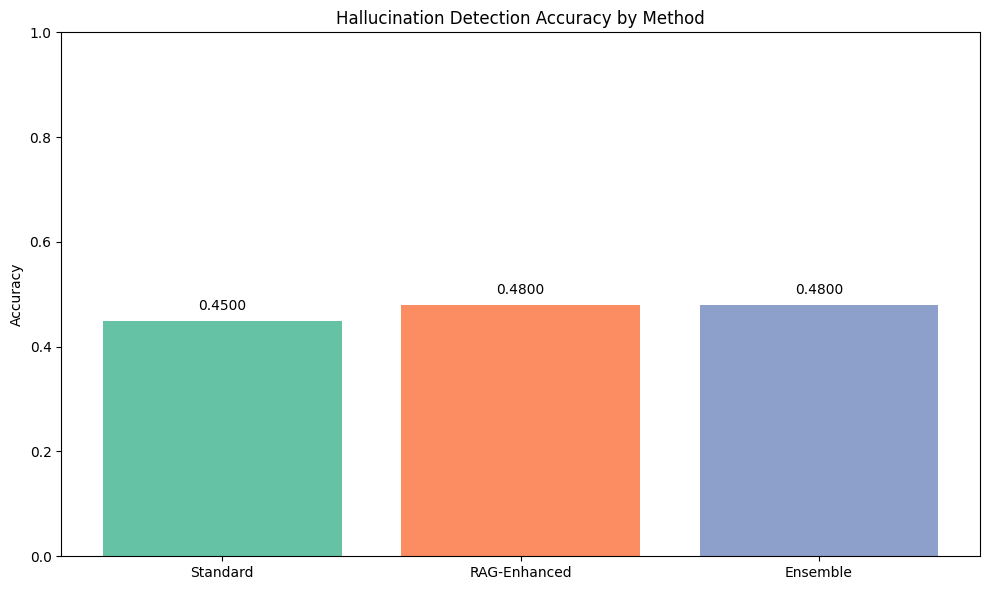

In [38]:

import matplotlib.pyplot as plt

accuracies = [
    standard_accuracy,
    rag_accuracy,
    ensemble_accuracy
]

plt.figure(figsize=(10, 6))
plt.bar(['Standard', 'RAG-Enhanced', 'Ensemble'], accuracies, color=plt.cm.Set2.colors[:len(method_names)])
plt.title('Hallucination Detection Accuracy by Method')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center')
plt.tight_layout()
plt.savefig('hallucination_detection_results.png')
plt.show()


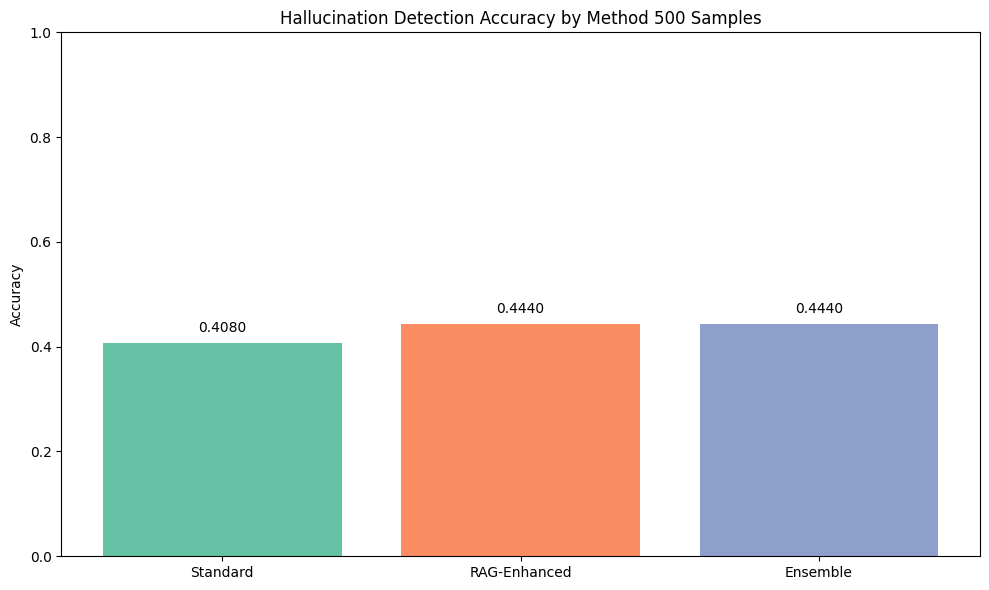

In [40]:
import matplotlib.pyplot as plt

# Dictionary of method names and their corresponding accuracies
accuracy_dict = {
    'Standard': acc_standard_500,
    'RAG-Enhanced': acc_rag_500,
    'Ensemble': acc_ensemble_500,
    # Add more methods here if needed
}

# Extract names and values in the correct order
method_names = list(accuracy_dict.keys())
accuracies = list(accuracy_dict.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(method_names, accuracies, color=plt.cm.Set2.colors[:len(method_names)])
plt.title('Hallucination Detection Accuracy by Method 500 Samples')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)

# Annotate accuracy values on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center')

plt.tight_layout()
plt.savefig('hallucination_detection_results.png')
plt.show()


In [ ]:
# def run_hallucination_detection_pipeline(file_path, balanced=True, sample_size=100):
#     """Run the complete hallucination detection pipeline."""
#     # Set up OpenAI API key
#     openai.api_key = os.getenv("OPENAI_API_KEY")
#     if not openai.api_key:
#         print("Warning: OpenAI API key not found in environment variables")
#         openai.api_key = input("Please enter your OpenAI API key: ")
    
#     # Step 1: Process data
#     df = process_fever_data(file_path, balanced_sampling=balanced)
    
#     # Step 2: Split data
#     train_data, val_data, test_data = create_train_val_test_split(df)
    
#     # Step 3: Add NLP features
#     train_data, val_data, test_data = add_nlp_features(train_data, val_data, test_data)
    
#     # Step 4: Set up RAG system
#     vector_store = setup_rag_system(train_data)
    
#     # Step 5: Augment test data with RAG
#     test_data = augment_evidence_with_rag(test_data, vector_store)
    
#     # Step 6: Train ML model
#     ml_model = train_ml_model(train_data, val_data)
    
#     # Step 7: Evaluate standard approach
#     standard_results, standard_accuracy = evaluate_standard_approach(test_data, sample_size=sample_size)
    
#     # Step 8: Evaluate RAG approach
#     rag_results, rag_accuracy = evaluate_rag_approach(test_data, sample_size=sample_size)
    
#     # Save cached LLM responses to file
#     with open(CACHE_FILE, "w") as f:
#         json.dump(llm_cache, f, indent=2)
    
#     # Step 9: Evaluate ensemble approach
#     ensemble_results, ensemble_accuracy = evaluate_ensemble_approach(test_data, ml_model, rag_results, sample_size=sample_size)
    
#     # Step 10: Print summary
#     print("\n=== Hallucination Detection Results ===")
#     print(f"Standard approach accuracy: {standard_accuracy:.4f}")
#     print(f"RAG-enhanced approach accuracy: {rag_accuracy:.4f}")
#     print(f"Ensemble approach accuracy: {ensemble_accuracy:.4f}")
    
#     return {
#         'train_data': train_data,
#         'val_data': val_data,
#         'test_data': test_data,
#         'ml_model': ml_model,
#         'vector_store': vector_store,
#         'standard_results': standard_results,
#         'rag_results': rag_results,
#         'ensemble_results': ensemble_results,
#         'accuracies': {
#             'standard': standard_accuracy,
#             'rag': rag_accuracy,
#             'ensemble': ensemble_accuracy
#         }
#     }

## Main execution

In [ ]:
# if __name__ == "__main__":
#     # Example usage:
#     results = run_hallucination_detection_pipeline(
#         file_path="/Users/shubhamgaur/Desktop/NU/Sem4/IR/Project/Milestone2/train.jsonl",
#         balanced=True,
#         sample_size=100
#     )
    
#     # Optional: Visualize results
#     accuracies = [
#         results['accuracies']['standard'],
#         results['accuracies']['rag'],
#         results['accuracies']['ensemble']
#     ]
    
#     plt.figure(figsize=(10, 6))
#     plt.bar(['Standard', 'RAG-Enhanced', 'Ensemble'], accuracies, color=['blue', 'green', 'red'])
#     plt.title('Hallucination Detection Accuracy by Method')
#     plt.ylabel('Accuracy')
#     plt.ylim(0, 1.0)
#     for i, acc in enumerate(accuracies):
#         plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center')
#     plt.tight_layout()
#     plt.savefig('hallucination_detection_results.png')
#     plt.show()